# Verifying the EKF code with a Toy Example

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import json
import matplotlib.pyplot as plt

# Get environment variables
import sys

sys.path.append("..")  # Add the parent directory of notebooks to sys.path

from lac.plotting import pose_traces
from lac.localization.ekf import EKF
from lac.localization.imu_dynamics import *

%load_ext autoreload
%autoreload 2

## Load IMU and Ground Truth Measurement Data

In [2]:
casename = "20hz_seed4"
data_path = "../../output/imu/" + casename + ".json"
json_data = json.load(open(f"{data_path}"))

poses = []
imu_data = []

for frame in json_data["frames"]:
    poses.append(np.array(frame["pose"]))
    imu_data.append(np.array(frame["imu"]))

imu_data = np.array(imu_data)

In [3]:
from scipy.spatial.transform import Rotation
from lac.util import skew_symmetric, normalize_rotation_matrix

gt_rotations_euler = np.zeros((len(poses), 3))
imu_rotations_euler = np.zeros((len(poses), 3))

for i in range(len(poses)):
    gt_rotations_euler[i] = Rotation.from_matrix(poses[i][:3, :3]).as_euler("xyz", degrees=False)

gt_translations = np.zeros((len(poses), 6))
for i in range(len(poses)):
    gt_translations[i, :3] = poses[i][:3, 3]
    if i > 0:
        dt = json_data["frames"][i]["mission_time"] - json_data["frames"][i - 1]["mission_time"]
        gt_translations[i, 3:] = (gt_translations[i, :3] - gt_translations[i - 1, :3]) / dt

## Toy Measurement Model

In [ ]:
import numpy as np

# -------------------------
# Helper: Build rotation matrix from an optical axis direction.
# -------------------------
def rotation_matrix_from_direction(direction, up_vector=np.array([0, 0, 1])):
    """
    Constructs a rotation matrix given a desired optical axis (direction)
    and a chosen up_vector to resolve the remaining degree of freedom.
    The optical axis is assumed to be the third column (z-axis) of the rotation matrix.
    
    Parameters:
      direction : array_like, shape (3,)
                  The desired optical axis (should be nonzero).
      up_vector : array_like, shape (3,), optional
                  A vector used to define the camera's "up" direction. Default is [0,0,1].
    
    Returns:
      R : ndarray, shape (3,3)
          The rotation matrix whose third column is the normalized direction.
    """
    # Normalize the optical axis
    z_axis = direction / np.linalg.norm(direction)
    
    # If the up vector is nearly parallel to the optical axis, choose an alternative.
    if np.abs(np.dot(z_axis, up_vector)) > 0.99:
        up_vector = np.array([0, 1, 0])
    
    # Compute the right vector (x-axis) as cross(up, optical axis)
    x_axis = np.cross(up_vector, z_axis)
    x_axis /= np.linalg.norm(x_axis)
    
    # Compute the true up vector (y-axis) as cross(z_axis, x_axis)
    y_axis = np.cross(z_axis, x_axis)
    
    # Form the rotation matrix: columns are [x_axis, y_axis, z_axis]
    R = np.column_stack((x_axis, y_axis, z_axis))
    return R

# -------------------------
# Standard rotation matrix functions (for the rover orientation)
# using a ZYX convention (yaw, pitch, roll)
# -------------------------
def rot_x(phi):
    return np.array([
        [1, 0, 0],
        [0, np.cos(phi), -np.sin(phi)],
        [0, np.sin(phi),  np.cos(phi)]
    ])

def rot_y(theta):
    return np.array([
        [ np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])

def rot_z(psi):
    return np.array([
        [np.cos(psi), -np.sin(psi), 0],
        [np.sin(psi),  np.cos(psi), 0],
        [0, 0, 1]
    ])

def d_rot_x(phi):
    return np.array([
        [0, 0, 0],
        [0, -np.sin(phi), -np.cos(phi)],
        [0,  np.cos(phi), -np.sin(phi)]
    ])

def d_rot_y(theta):
    return np.array([
        [-np.sin(theta), 0,  np.cos(theta)],
        [0, 0, 0],
        [-np.cos(theta), 0, -np.sin(theta)]
    ])

def d_rot_z(psi):
    return np.array([
        [-np.sin(psi), -np.cos(psi), 0],
        [ np.cos(psi), -np.sin(psi), 0],
        [0, 0, 0]
    ])

# -------------------------
# Measurement Model with Camera Extrinsics given by translation and a direction vector.
# -------------------------
def measurement_model_and_jacobian_direction(rover_state, cam_trans, cam_direction, p_lander, K, with_noise=False):
    """
    Computes the pixel measurement (lander center) and the Jacobian with respect
    to the rover state, given that the camera extrinsics are specified by a translation
    (cam_trans) and a direction vector (cam_direction) for its optical axis, both expressed
    in the rover body frame.
    
    Parameters:
      rover_state: ndarray, shape (9,)
                   [x, y, z, dx, dy, dz roll, pitch, yaw] in world coordinates (angles in radians)
      cam_trans: ndarray, shape (3,)
                 Camera translation from rover body frame to camera (dx, dy, dz)
      cam_direction: ndarray, shape (3,)
                     The camera's optical axis direction (e.g., [1,0,0] or [0,0,1])
                     expressed in the rover body frame.
      p_lander: ndarray, shape (3,)
                Lander center position in world coordinates.
      K: ndarray, shape (3,3)
         Camera intrinsic matrix.
    
    Returns:
      measurement: ndarray, shape (2,), pixel coordinates [u, v]
      H: ndarray, shape (2,6), Jacobian of the measurement with respect to rover_state.
         (Note: The Jacobian here is computed assuming the camera's direction is fixed.)
    """
    # Unpack rover state
    x, y, z, dx, dy, dz, roll, pitch, yaw = rover_state
    t_rover = np.array([x, y, z])
    
    # Rover orientation from world to rover body frame (ZYX convention)
    R_rover = rot_z(yaw) @ rot_y(pitch) @ rot_x(roll)
    
    # Compute the camera's rotation matrix from the given direction vector.
    # Here we assume that the provided cam_direction should become the camera's optical axis.
    # We choose a default up vector (e.g. [0,0,1]); adjust if needed.
    R_cam_body = rotation_matrix_from_direction(cam_direction, up_vector=np.array([0, 0, 1]))
    
    # Compute camera pose in world frame
    t_cam = t_rover + R_rover @ cam_trans   # Camera translation in world frame
    R_cam = R_rover @ R_cam_body            # Camera rotation in world frame

    # Transform lander center from world coordinates to camera frame
    d_vec = p_lander - t_cam
    p_c = R_cam.T @ d_vec  # p_c = [X, Y, Z] in camera frame
    X, Y, Z = p_c

    # Project to image plane using intrinsic matrix K
    fx, fy, cx, cy = K[0,0], K[1,1], K[0,2], K[1,2]
    u = fx * (X / Z) + cx
    v = fy * (Y / Z) + cy
    measurement = np.array([u, v])
    
    # --- Jacobian Computation ---
    # (For the sake of this example, we assume the camera's direction is fixed, so
    # the only derivatives come from the rover state affecting t_cam and R_rover.)
    
    # 1. Derivative of projection with respect to p_c:
    J_proj = np.array([
        [fx / Z,       0,       -fx * X / (Z**2)],
        [0,       fy / Z,       -fy * Y / (Z**2)]
    ])  # 2x3

    # 2. Derivative of p_c with respect to rover state.
    # p_c = R_cam.T (p_lander - t_cam) with t_cam = t_rover + R_rover * cam_trans and R_cam = R_rover * R_cam_body.
    
    # a) Derivative with respect to rover position (x, y, z):
    J_pos = -R_cam.T  # 3x3

    # b) Derivative with respect to rover orientation (roll, pitch, yaw)
    # Compute derivatives of R_rover:
    dR_droll   = rot_z(yaw) @ rot_y(pitch) @ d_rot_x(roll)
    dR_dpitch  = rot_z(yaw) @ d_rot_y(pitch) @ rot_x(roll)
    dR_dyaw    = d_rot_z(yaw) @ rot_y(pitch) @ rot_x(roll)
    
    # The derivative of camera rotation:
    dR_cam_droll   = dR_droll   @ R_cam_body
    dR_cam_dpitch  = dR_dpitch  @ R_cam_body
    dR_cam_dyaw    = dR_dyaw    @ R_cam_body

    # Also, the derivative of camera translation:
    dt_cam_droll   = dR_droll   @ cam_trans
    dt_cam_dpitch  = dR_dpitch  @ cam_trans
    dt_cam_dyaw    = dR_dyaw    @ cam_trans

    # For each Euler angle, the derivative of p_c is:
    # dp_c/d(angle) = (dR_cam/d(angle))^T (p_lander - t_cam) - R_cam^T (d(t_cam)/d(angle))
    dp_c_droll   = (dR_cam_droll.T)   @ d_vec - R_cam.T @ dt_cam_droll
    dp_c_dpitch  = (dR_cam_dpitch.T)  @ d_vec - R_cam.T @ dt_cam_dpitch
    dp_c_dyaw    = (dR_cam_dyaw.T)    @ d_vec - R_cam.T @ dt_cam_dyaw

    J_orient = np.column_stack((dp_c_droll, dp_c_dpitch, dp_c_dyaw))  # 3x3

    # Combine to get derivative of p_c with respect to rover state (6 columns)
    J_cam = np.hstack((J_pos, J_orient))  # 3x6

    # Final Jacobian: d(measurement)/d(rover_state) = J_proj * J_cam
    H = J_proj @ J_cam  # 2x6
    H_all = np.zeros((2, 9))
    H_all[:, :3] = H[:, :3]
    H_all[:, 6:] = H[:, 3:]

    # Meas error
    pix_noise = 2.0
    R = np.eye(2) * (pix_noise ** 2)

    if with_noise:
        measurement += np.random.multivariate_normal([0, 0], R)

    R_scale = 4.0
    R = R * R_scale

    return measurement, H_all, R

### Run Example Measurement Model

In [5]:
import os


# Sample rover state: [x, y, z, dx, dy, dz, roll, pitch, yaw] (world coordinates, radians)
rover_state = np.array([1.0, 2.0, 0.5, 0.0, 0.0, 0.0, 0.1, -0.05, 0.2])

cams_geoms = json.load(open(os.path.expanduser("../../docs/geometry.json")))[
    "rover"
]["cameras"]["front left"]

# Camera translation from rover body to camera (e.g., in meters or kilometers, as appropriate)
cam_trans = np.array([cams_geoms["x"], cams_geoms["y"], cams_geoms["z"]])

# Camera orientation given as a direction vector in the rover body frame.
# For example, if the camera optical axis is along [1, 0, 0] (pointing in the rover’s x direction):
cam_direction = np.array([1, 0, 0])
# Alternatively, using [0, 0, 1] means the camera optical axis is aligned with the rover’s z axis.
# Uncomment one of the following lines:
# cam_direction = np.array([1, 0, 0])
# cam_direction = np.array([0, 0, 1])

# Lander center position in world coordinates
p_lander = np.array(cams_geoms["orientation"])

# Camera intrinsic matrix K:
W, H = 1280, 720
FOV = 1.22  # radians
focal_length_x = W / (2 * np.tan(FOV / 2))
focal_length_y = H / (2 * np.tan(FOV / 2))
K = np.array([[focal_length_x, 0, W / 2], [0, focal_length_x, H / 2], [0, 0, 1]])

meas, jac, _ = measurement_model_and_jacobian_direction(rover_state, cam_trans, cam_direction, p_lander, K)
print("Pixel measurement [u, v]:", meas)
print("Jacobian (2x9):\n", jac)

# Compare with numerical Jacobian:
def numerical_jacobian(f, x, eps=1e-6):
    J = np.zeros((f(x).shape[0], x.shape[0]))
    for i in range(x.shape[0]):
        x_plus = x.copy()
        x_plus[i] += eps
        x_minus = x.copy()
        x_minus[i] -= eps
        J[:, i] = (f(x_plus) - f(x_minus)) / (2*eps)
    return J

J_num = numerical_jacobian(lambda x: measurement_model_and_jacobian_direction(x, cam_trans, cam_direction, p_lander, K)[0], rover_state)

print("Numerical Jacobian (2x9):\n", J_num)
print("Jacobian Difference (should be close to zero):\n", jac - J_num)



Pixel measurement [u, v]: [3352.80831679  898.11464458]
Jacobian (2x9):
 [[-4047.83751536   504.07740215   -63.09304106     0.
      0.             0.           367.19517253  1908.4334661
  -8095.67503072]
 [ -788.21863656  -292.68460823  1258.26768508     0.
      0.             0.         -2607.12528446   915.2854964
  -1576.43727312]]
Numerical Jacobian (2x9):
 [[-4047.8375156    504.07740196   -63.09304126     0.
      0.             0.           367.1951722   1908.43346627
  -8095.67503075]
 [ -788.21863656  -292.68460821  1258.26768516     0.
      0.             0.         -2607.1252845    915.28549649
  -1576.43727317]]
Jacobian Difference (should be close to zero):
 [[ 2.41777798e-07  1.98222722e-07  2.04925122e-07  0.00000000e+00
   0.00000000e+00  0.00000000e+00  3.26187376e-07 -1.69115992e-07
   2.88091542e-08]
 [ 2.42039278e-10 -1.61792286e-08 -7.54816938e-08  0.00000000e+00
   0.00000000e+00  0.00000000e+00  3.91250978e-08 -9.00857913e-08
   5.73277248e-08]]


## Post-Processing Functions

In [6]:
def plot_results(data, title=""):
    times = data["times"]
    xerr = data["x_err"]
    P_store = data["P_store"]

    fig, axes = plt.subplots(3, 3, figsize=(15, 10))

    n_sim = xerr.shape[0]

    # positions -------------------------------
    pos_labels = ["X", "Y", "Z", "Vx", "Vy", "Vz"]

    for i in range(6):
        ax = axes.flatten()[i]

        ax.plot(times, xerr[:, i], label="True")
        # plot 3-sigma bounds
        ax.fill_between(
            times,
            - 3 * np.sqrt(P_store[:, i, i]),
            + 3 * np.sqrt(P_store[:, i, i]),
            alpha=0.2,
            label="3-sigma bound"
        )

        ax.legend()
        ax.grid()
        ax.set_xlabel("Time")
        ax.set_ylabel(f"{pos_labels[i]}")

    # angles -----------------------------
    RAD2DEG = 180 / np.pi
    pos_labels = ["Err Roll (deg)", "Err Pitch (deg)", "Err Yaw (deg)"]
    for i in range(3):
        ax = axes.flatten()[i + 6]
        ax.plot(times, xerr[:, i+6] * RAD2DEG, label="True")
        # plot 3-sigma bounds
        ax.fill_between(
            times,
            - 3 * np.sqrt(P_store[:, 6+i, 6+i]) * RAD2DEG,
            + 3 * np.sqrt(P_store[:, 6+i, 6+i]) * RAD2DEG,
            alpha=0.2,
            label="3-sigma bounds"
        )
        ax.legend()
        ax.grid()
        ax.set_xlabel("Time")
        ax.set_ylabel(f"{pos_labels[i]}")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

## Run EKF Model 

In [7]:
print(dt)

0.05000000074505806


In [ ]:
# Get Initial states
R_0 = poses[0][:3, :3]

imu_rotations = []
imu_rotations.append(R_0)

v0 = np.zeros(3)
# v0 = (gt_translations[1, :3] - gt_translations[0, :3]) / (json_data["frames"][1]["mission_time"] - json_data["frames"][0]["mission_time"])

x0 = np.hstack((gt_translations[0, :3], v0, gt_rotations_euler[0])).T

print("r0 :", gt_translations[0, :3])
print("v0 :", v0)
print("angle0 :", gt_rotations_euler[0])

init_r = 0.001
init_v = 0.01
init_angle = 0.001
P0 = np.diag(np.hstack((np.ones(3) * init_r * init_r, np.ones(3) * init_v * init_v, np.ones(3) * init_angle * init_angle)))

# Process noise
def create_Q(sigma_a, sigma_angle):
    dt2 = dt * dt
    dt3 = dt2 * dt
    Q_rvm = np.block([
        [np.eye(3) * dt3/3.0, np.eye(3) * dt2/2.0],
        [np.eye(3) * dt2/2.0, np.eye(3) *dt]
    ]
    ) * (sigma_a ** 2)

    Q_angle = np.eye(3) * sigma_angle ** 2

    Q_meas = np.block([
        [Q_rvm, np.zeros((6, 3))],
        [np.zeros((3, 6)), Q_angle]
    ])

    return Q_meas


Q_imu = create_Q(0.00, 0.00005)
Q_meas = create_Q(0.03, 0.00005)


ekfi = EKF(x0, P0, store=False)  # EKF with IMU-only
ekfm = EKF(x0, P0, store=True)  # EKF with IMU + Measurement

n_sim = len(poses)
# n_sim = 1000

x_store_imu = np.zeros((n_sim, 9))
P_store_imu = np.zeros((n_sim, 9, 9))
x_store_meas = np.zeros((n_sim, 9))
P_store_meas = np.zeros((n_sim, 9, 9))
true_states = np.zeros((n_sim, 9))

x_store_imu[0] = ekfi.x
P_store_imu[0] = ekfi.P
x_store_meas[0] = ekfm.x
P_store_meas[0] = ekfm.P

time = 0
times = [0]
meas_tidx = []

true_states[0] = np.hstack((
    gt_translations[0, :3],
    (gt_translations[1, :3] - gt_translations[0, :3]) / dt,
    gt_rotations_euler[0]
))

meas_inv = 20   # measurement interval

# Generate true measurements
true_meas = {}

for i in range(1, n_sim):

    # true rover pose
    true_rover_state = np.hstack((
        gt_translations[i, :3],
        (gt_translations[i, :3] - gt_translations[i - 1, :3]) / dt,
        gt_rotations_euler[i]
    ))

    true_states[i] = true_rover_state

    # sample image every 1 sec
    if (i % meas_inv == 0):
        # measurement ----------------------------------------
        p_lander = np.array([0.0, 0.0, 0.0])
        true_meas[i], _, _ = measurement_model_and_jacobian_direction(true_rover_state, cam_trans, cam_direction, p_lander, K, with_noise=True)


# Run EKF
for i in range(1, n_sim):
    # dt = json_data["frames"][i]["mission_time"] - json_data["frames"][i - 1]["mission_time"]
    dt = 1/20
    time += dt
    times.append(time)

    a_k = imu_data[i][:3]
    omega_k = imu_data[i][3:]

    dyn_func = lambda x: propagate_state(x, a_k, omega_k, dt, with_stm=True, use_numdiff=False)

    ekfi.predict(i, dyn_func, Q_imu)
    ekfm.predict(i, dyn_func, Q_meas)

    # sample image every 1 sec
    if (i % meas_inv == 0):
        # measurement ----------------------------------------
        p_lander = np.array([0.0, 0.0, 0.0])
        meas_func = lambda x: measurement_model_and_jacobian_direction(x, cam_trans, cam_direction, p_lander, K)
                                                        
        ekfm.update(i, true_meas[i], meas_func)

        # Compute error
        # error = ekfm.x - true_rover_state

        # print("Time: {:.2f} s |  x_err: {:.3f} m | y_err: {:.3f} m | z_err: {:.3f} m | roll_err: {:.3f} deg | pitch_err: {:.3f} deg | yaw_err: {:.3f} deg".format(
        #     time,
        #     error[0], error[1], error[2],
        #     error[6] * 180 / np.pi, error[7] * 180 / np.pi, error[8] * 180 / np.pi
        # ))

        meas_tidx.append(i)

    x_store_imu[i] = ekfi.x
    P_store_imu[i] = ekfi.P
    x_store_meas[i] = ekfm.x
    P_store_meas[i] = ekfm.P

# smooth
rms_error = np.sqrt(np.mean((x_store_meas[:, :3] - true_states[:, :3]) ** 2, axis=0))
print(f"EKF | RMS Position Error: {rms_error}")

# run smoother
ekfm.smooth()

# run iterations 
n_iter = 3
for itr in range(n_iter):
    # Compute the rms position error
    res = ekfm.get_array()
    rms_err = np.sqrt(np.mean((res["xhat_smooth"][:, :3] - true_states[:, :3]) ** 2, axis=0))

    print(f"Iteration {itr+1} | RMS Position Error: {rms_err}")

    ekfm = EKF(ekfm.xhat_store_smooth[0], P0, store=True)  # EKF with IMU + Measurement

    for i in range(1, n_sim):
        a_k = imu_data[i][:3]
        omega_k = imu_data[i][3:]

        dyn_func = lambda x: propagate_state(x, a_k, omega_k, dt, with_stm=True, use_numdiff=False)
        ekfm.predict(i, dyn_func, Q_meas)

        # sample image every 1 sec
        if (i % meas_inv == 0):
            # measurement ----------------------------------------
            p_lander = np.array([0.0, 0.0, 0.0])
            meas_func = lambda x: measurement_model_and_jacobian_direction(x, cam_trans, cam_direction, p_lander, K)                                         
            ekfm.update(i, true_meas[i], meas_func)

    # run smoother
    ekfm.smooth()

res = ekfm.get_array()

data_imu = {'times': times, 'x_err': x_store_imu - true_states, 'P_store': P_store_imu}
data_meas = {'times': times, 'x_err': x_store_meas - true_states, 'P_store': P_store_meas}  
data_smooth = {'times': times, 'x_err': res["xhat_smooth"] - true_states, 'P_store': res["Phat_smooth"]}

rms_pos = {}
rms_angle = {}

rms_pos["imu"] = np.sqrt(np.mean(data_imu["x_err"][:, :3] ** 2, axis=0))
rms_pos["meas"] = np.sqrt(np.mean(data_meas["x_err"][:, :3] ** 2, axis=0))
rms_pos["smooth"] = np.sqrt(np.mean(data_smooth["x_err"][:, :3] ** 2, axis=0))

rms_angle["imu"] = np.sqrt(np.mean(data_imu["x_err"][:, 6:] ** 2, axis=0))
rms_angle["meas"] = np.sqrt(np.mean(data_meas["x_err"][:, 6:] ** 2, axis=0))
rms_angle["smooth"] = np.sqrt(np.mean(data_smooth["x_err"][:, 6:] ** 2, axis=0))

r0 : [-9.38848877  2.8519876   1.86459863]
v0 : [0. 0. 0.]
angle0 : [0.08498921 0.02596164 0.26355474]
EKF | RMS Position Error: [0.25414323 0.13298617 0.06742789]
Iteration 1 | RMS Position Error: [0.03660915 0.02187199 0.01100639]
Iteration 2 | RMS Position Error: [0.03897893 0.03320584 0.01235063]
Iteration 3 | RMS Position Error: [0.04881349 0.04511059 0.01546541]


## Plot the IMU-only result

IMU RMS Pos:  [8.31791638 2.99786839 0.52479319]
IMU RMS Angle:  [0.00042381 0.00249536 0.00104101]


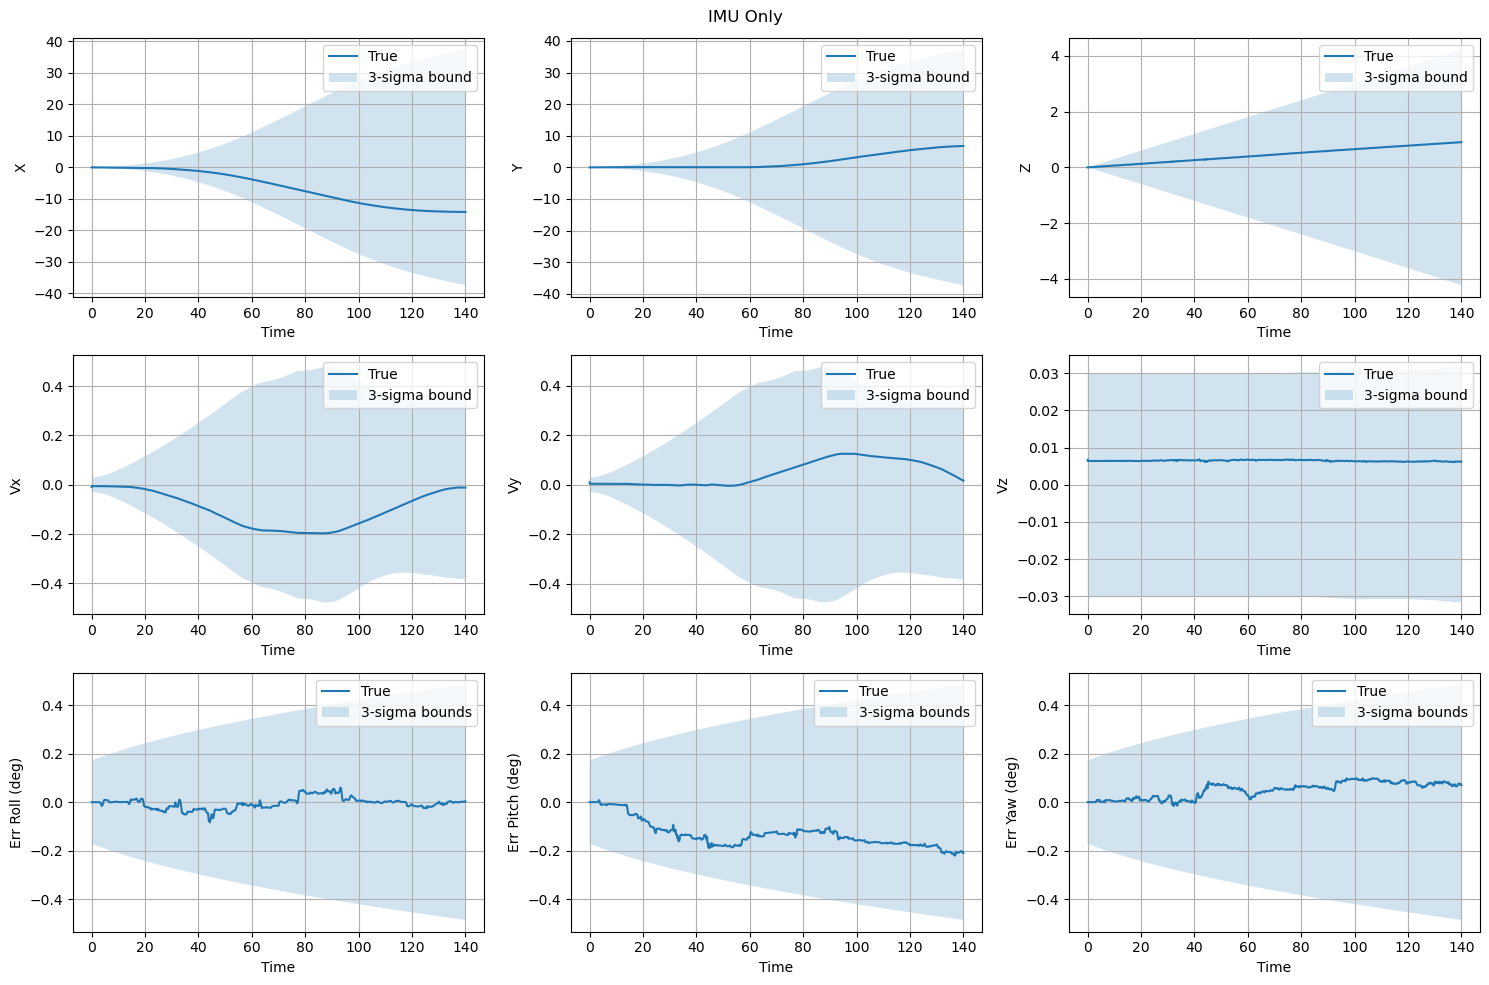

In [13]:
print("IMU RMS Pos: ", rms_pos["imu"])
print("IMU RMS Angle: ", rms_angle["imu"])

plot_results(data_imu, title="IMU Only")

### Plot IMU + Measureent Result

Measurement RMS Pos:  [0.25414323 0.13298617 0.06742789]
Measurement RMS Angle:  [0.0005994  0.00172491 0.00099948]


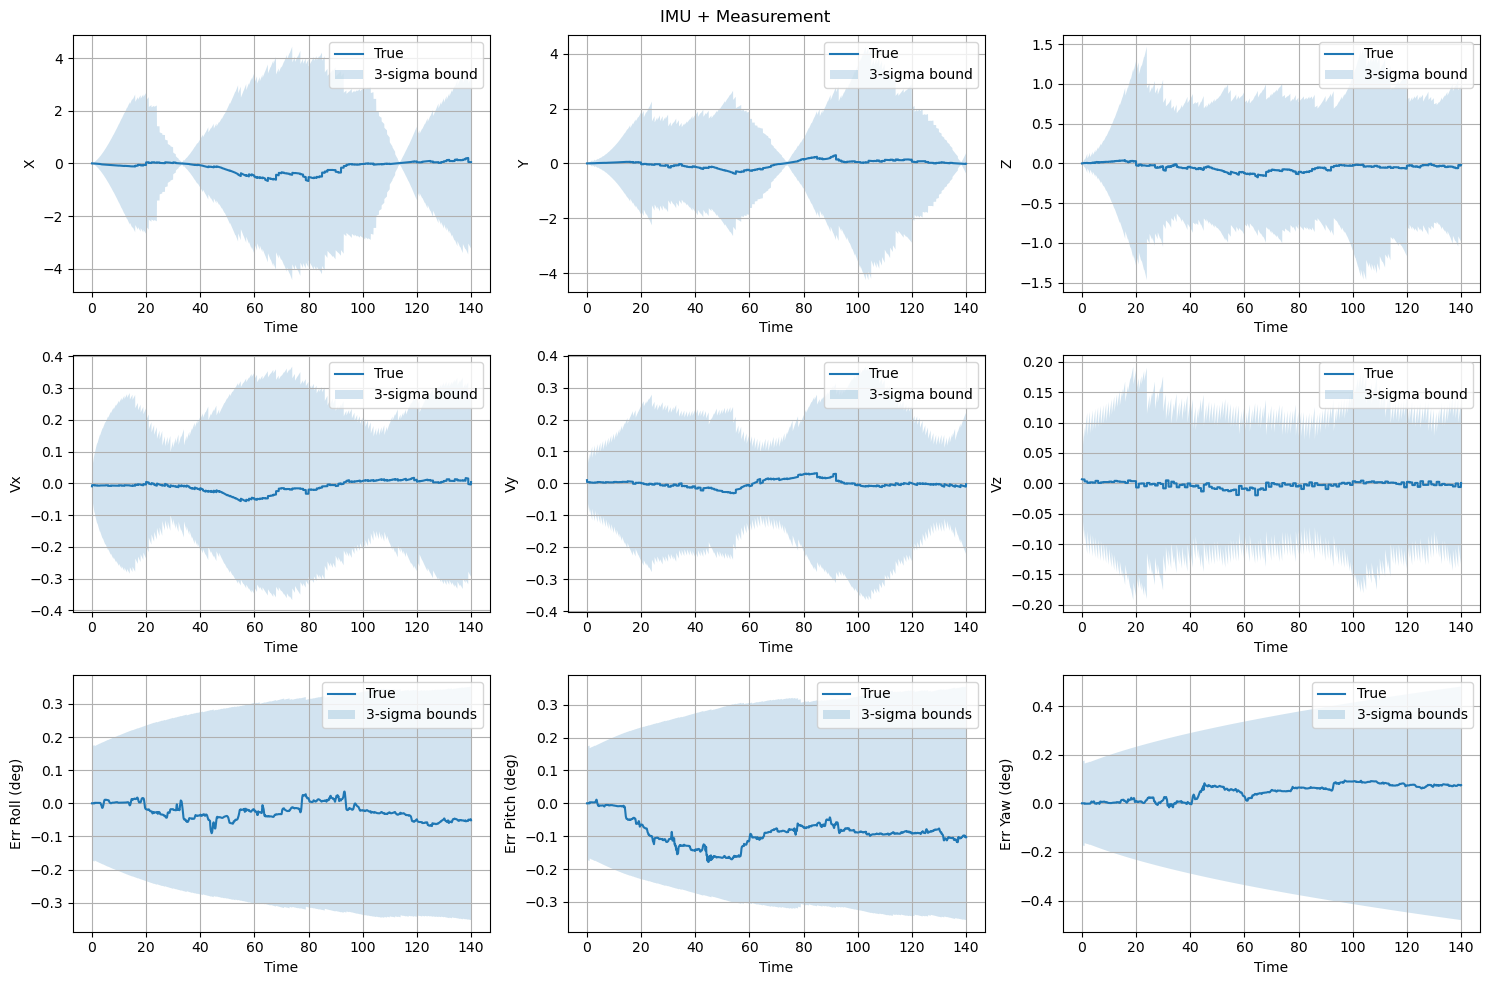

In [14]:
print("Measurement RMS Pos: ", rms_pos["meas"])
print("Measurement RMS Angle: ", rms_angle["meas"])

plot_results(data_meas, title="IMU + Measurement")

### Smoothing

Smoothed RMS Pos:  [0.06277447 0.05731974 0.01953089]
Smoothed RMS Angle:  [0.00185237 0.00087966 0.00102437]


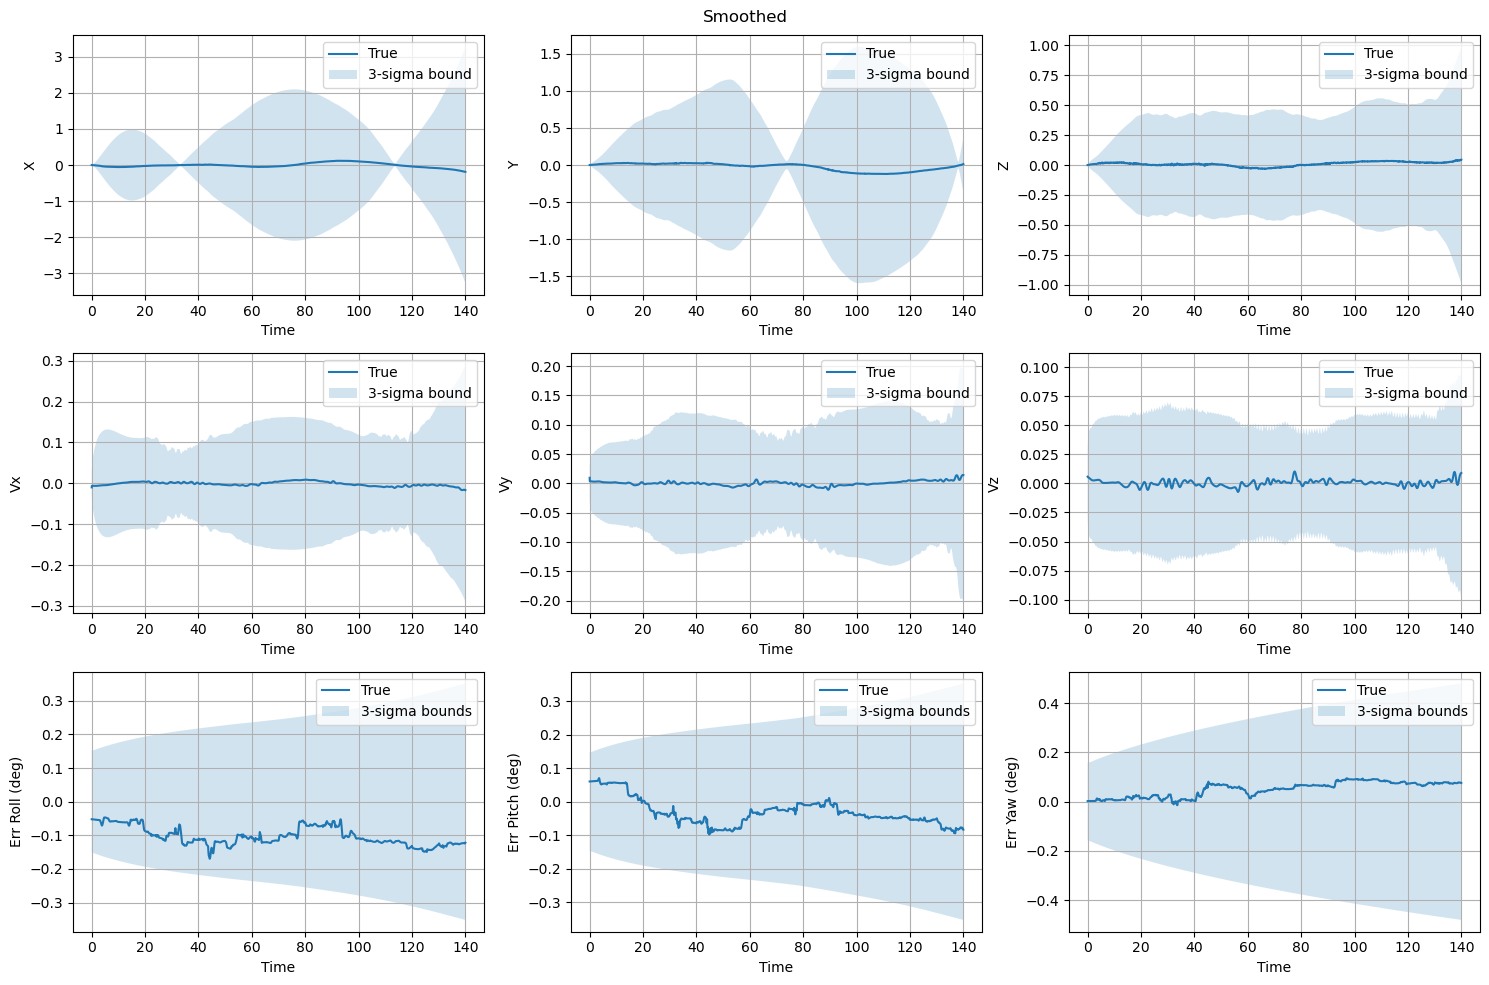

In [15]:
print("Smoothed RMS Pos: ", rms_pos["smooth"])
print("Smoothed RMS Angle: ", rms_angle["smooth"])

plot_results(data_smooth, title="Smoothed")